<a href="https://colab.research.google.com/github/zjzsu2000/CMPE297_Sec49AdvanceDL/blob/master/Assignment_4/Assignment_4_a)MTL_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assigntment_4_a)MTL_task

Multi task learning with NLP problem:
* STS-B: A two-sentece textual similarity scoring task. (Prediction is a real integer number 1 -5)
* RTE: A two-sentence natural language entailment task. (Prediction is classes 0/1)
* Commonsense QA: A multiple-choice question-answering task. (Each example consists of 5 seperate text inputs, prediction the correct one)

refs:
* https://ruder.io/multi-task/
* https://github.com/huggingface/nlp
* https://github.com/zphang/zphang.github.io/tree/master/files/notebooks
* https://autokeras.com/tutorial/multi/



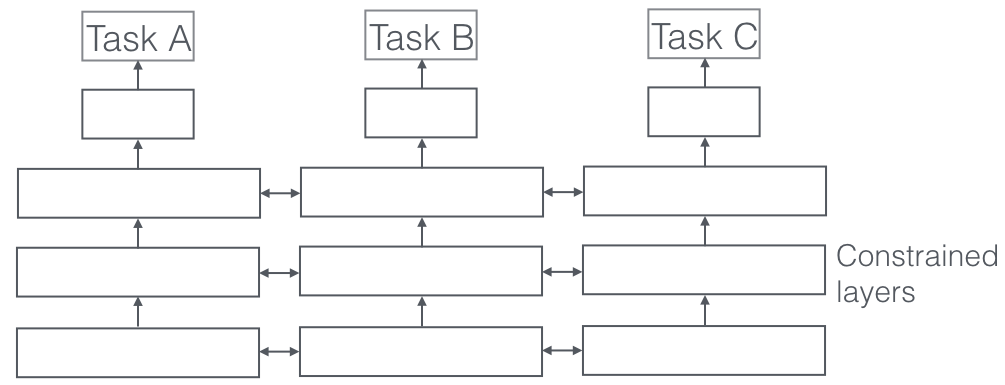

In [2]:
!pip install git+https://github.com/huggingface/nlp
!pip install transformers==2.11.0
!pip install nlp==0.2.0

  Cloning https://github.com/huggingface/nlp to /tmp/pip-req-build-udvb1275
  Running command git clone -q https://github.com/huggingface/nlp /tmp/pip-req-build-udvb1275
     |████████████████████████████████| 17.7MB 202kB/s 
     |████████████████████████████████| 245kB 54.0MB/s 
  Created wheel for datasets: filename=datasets-1.1.2-cp36-none-any.whl size=147310 sha256=5115f15d67df541a20074258e9cfea863b6d8013186ff210a19774c5a3ea8ff3
  Stored in directory: /tmp/pip-ephem-wheel-cache-8lfw8het/wheels/ec/83/70/1320deb5c8c3b17b432b2a896067946c05dd5e8b1c32b91731
Successfully built datasets
  Found existing installation: pyarrow 0.14.1
    Uninstalling pyarrow-0.14.1:
      Successfully uninstalled pyarrow-0.14.1
     |████████████████████████████████| 675kB 11.9MB/s 
     |████████████████████████████████| 1.1MB 49.2MB/s 
     |████████████████████████████████| 3.8MB 48.6MB/s 
     |████████████████████████████████| 890kB 51.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import numpy as np
import torch
import torch.nn as nn
import transformers
import nlp
import logging
logging.basicConfig(level=logging.INFO)
import dataclasses
from torch.utils.data.dataloader import DataLoader
from transformers.training_args import is_tpu_available
from transformers.trainer import get_tpu_sampler
from transformers.data.data_collator import DataCollator, InputDataClass
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data.sampler import RandomSampler
from typing import List, Union, Dict


## Reading the data

In [5]:
dataset_dict = {"stsb": nlp.load_dataset('glue', name="stsb"),  "rte": nlp.load_dataset('glue', name="rte"),"commonsense_qa": nlp.load_dataset('commonsense_qa'),}

INFO:filelock:Lock 140636585394976 acquired on /root/.cache/huggingface/datasets/5fe6ab0df8a32a3371b2e6a969d31d855a19563724fb0d0f163748c270c0ac60.2ea96febf19981fae5f13f0a43d4e2aa58bc619bc23acf06de66675f425a5538.py.lock
INFO:nlp.utils.file_utils:https://s3.amazonaws.com/datasets.huggingface.co/nlp/datasets/glue/glue.py not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/tmp55exkrce


INFO:nlp.utils.file_utils:storing https://s3.amazonaws.com/datasets.huggingface.co/nlp/datasets/glue/glue.py in cache at /root/.cache/huggingface/datasets/5fe6ab0df8a32a3371b2e6a969d31d855a19563724fb0d0f163748c270c0ac60.2ea96febf19981fae5f13f0a43d4e2aa58bc619bc23acf06de66675f425a5538.py
INFO:nlp.utils.file_utils:creating metadata file for /root/.cache/huggingface/datasets/5fe6ab0df8a32a3371b2e6a969d31d855a19563724fb0d0f163748c270c0ac60.2ea96febf19981fae5f13f0a43d4e2aa58bc619bc23acf06de66675f425a5538.py
INFO:filelock:Lock 140636585394976 released on /root/.cache/huggingface/datasets/5fe6ab0df8a32a3371b2e6a969d31d855a19563724fb0d0f163748c270c0ac60.2ea96febf19981fae5f13f0a43d4e2aa58bc619bc23acf06de66675f425a5538.py.lock
INFO:filelock:Lock 140637656618488 acquired on /root/.cache/huggingface/datasets/23cce469d199e8c3aa4ce9bf9f72ede6da5dc1f8f73d38715bef3d9ec89cdc6a.c03a84103b958f3697ef9b9ea8027aca1786cd9117647dd97ada56e4d77d0fbe.lock
INFO:nlp.utils.file_utils:https://s3.amazonaws.com/datase

INFO:nlp.utils.file_utils:storing https://s3.amazonaws.com/datasets.huggingface.co/nlp/datasets/glue/dataset_infos.json in cache at /root/.cache/huggingface/datasets/23cce469d199e8c3aa4ce9bf9f72ede6da5dc1f8f73d38715bef3d9ec89cdc6a.c03a84103b958f3697ef9b9ea8027aca1786cd9117647dd97ada56e4d77d0fbe
INFO:nlp.utils.file_utils:creating metadata file for /root/.cache/huggingface/datasets/23cce469d199e8c3aa4ce9bf9f72ede6da5dc1f8f73d38715bef3d9ec89cdc6a.c03a84103b958f3697ef9b9ea8027aca1786cd9117647dd97ada56e4d77d0fbe
INFO:filelock:Lock 140637656618488 released on /root/.cache/huggingface/datasets/23cce469d199e8c3aa4ce9bf9f72ede6da5dc1f8f73d38715bef3d9ec89cdc6a.c03a84103b958f3697ef9b9ea8027aca1786cd9117647dd97ada56e4d77d0fbe.lock
INFO:nlp.load:Checking /root/.cache/huggingface/datasets/5fe6ab0df8a32a3371b2e6a969d31d855a19563724fb0d0f163748c270c0ac60.2ea96febf19981fae5f13f0a43d4e2aa58bc619bc23acf06de66675f425a5538.py for additional imports.
INFO:filelock:Lock 140636585397888 acquired on /root/.cac

INFO:nlp.utils.file_utils:storing https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FSTS-B.zip?alt=media&token=bddb94a7-8706-4e0d-a694-1109e12273b5 in cache at /root/.cache/huggingface/datasets/downloads/e9bb78c83f40c69507171fc0f3e25e9dd62da6a8f8cf46b60514a45e4937aae0
INFO:nlp.utils.file_utils:creating metadata file for /root/.cache/huggingface/datasets/downloads/e9bb78c83f40c69507171fc0f3e25e9dd62da6a8f8cf46b60514a45e4937aae0
INFO:filelock:Lock 140636585397720 released on /root/.cache/huggingface/datasets/downloads/e9bb78c83f40c69507171fc0f3e25e9dd62da6a8f8cf46b60514a45e4937aae0.lock
INFO:filelock:Lock 140636580809752 acquired on /root/.cache/huggingface/datasets/downloads/e9bb78c83f40c69507171fc0f3e25e9dd62da6a8f8cf46b60514a45e4937aae0.lock
INFO:filelock:Lock 140636580809752 released on /root/.cache/huggingface/datasets/downloads/e9bb78c83f40c69507171fc0f3e25e9dd62da6a8f8cf46b60514a45e4937aae0.lock
INFO:nlp.utils.info_utils:All the checksums

INFO:nlp.arrow_writer:Done writing 5749 examples in 754799 bytes /root/.cache/huggingface/datasets/glue/stsb/1.0.0.incomplete/glue-train.arrow.
INFO:nlp.builder:Generating split validation


INFO:nlp.arrow_writer:Done writing 1500 examples in 216072 bytes /root/.cache/huggingface/datasets/glue/stsb/1.0.0.incomplete/glue-validation.arrow.
INFO:nlp.builder:Generating split test


INFO:nlp.arrow_writer:Done writing 1379 examples in 169982 bytes /root/.cache/huggingface/datasets/glue/stsb/1.0.0.incomplete/glue-test.arrow.
INFO:nlp.utils.info_utils:All the splits matched successfully.
INFO:nlp.builder:Constructing Dataset for split None, from /root/.cache/huggingface/datasets/glue/stsb/1.0.0


Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/stsb/1.0.0. Subsequent calls will reuse this data.


INFO:nlp.load:Checking /root/.cache/huggingface/datasets/5fe6ab0df8a32a3371b2e6a969d31d855a19563724fb0d0f163748c270c0ac60.2ea96febf19981fae5f13f0a43d4e2aa58bc619bc23acf06de66675f425a5538.py for additional imports.
INFO:filelock:Lock 140636580809752 acquired on /root/.cache/huggingface/datasets/5fe6ab0df8a32a3371b2e6a969d31d855a19563724fb0d0f163748c270c0ac60.2ea96febf19981fae5f13f0a43d4e2aa58bc619bc23acf06de66675f425a5538.py.lock
INFO:nlp.load:Found main folder for dataset https://s3.amazonaws.com/datasets.huggingface.co/nlp/datasets/glue/glue.py at /usr/local/lib/python3.6/dist-packages/nlp/datasets/glue
INFO:nlp.load:Found specific version folder for dataset https://s3.amazonaws.com/datasets.huggingface.co/nlp/datasets/glue/glue.py at /usr/local/lib/python3.6/dist-packages/nlp/datasets/glue/637080968c182118f006d3ea39dd9937940e81cfffc8d79836eaae8bba307fc4
INFO:nlp.load:Found script file from https://s3.amazonaws.com/datasets.huggingface.co/nlp/datasets/glue/glue.py to /usr/local/lib/py

INFO:nlp.utils.file_utils:storing https://firebasestorage.googleapis.com/v0/b/mtl-sentence-representations.appspot.com/o/data%2FRTE.zip?alt=media&token=5efa7e85-a0bb-4f19-8ea2-9e1840f077fb in cache at /root/.cache/huggingface/datasets/downloads/e8b62ee44e6f8b6aea761935928579ffe1aa55d161808c482e0725abbdcf9c64
INFO:nlp.utils.file_utils:creating metadata file for /root/.cache/huggingface/datasets/downloads/e8b62ee44e6f8b6aea761935928579ffe1aa55d161808c482e0725abbdcf9c64
INFO:filelock:Lock 140636571520640 released on /root/.cache/huggingface/datasets/downloads/e8b62ee44e6f8b6aea761935928579ffe1aa55d161808c482e0725abbdcf9c64.lock
INFO:filelock:Lock 140636571520640 acquired on /root/.cache/huggingface/datasets/downloads/e8b62ee44e6f8b6aea761935928579ffe1aa55d161808c482e0725abbdcf9c64.lock
INFO:filelock:Lock 140636571520640 released on /root/.cache/huggingface/datasets/downloads/e8b62ee44e6f8b6aea761935928579ffe1aa55d161808c482e0725abbdcf9c64.lock
INFO:nlp.utils.info_utils:All the checksums m

INFO:nlp.arrow_writer:Done writing 2490 examples in 847328 bytes /root/.cache/huggingface/datasets/glue/rte/1.0.0.incomplete/glue-train.arrow.
INFO:nlp.builder:Generating split validation


INFO:nlp.arrow_writer:Done writing 277 examples in 90736 bytes /root/.cache/huggingface/datasets/glue/rte/1.0.0.incomplete/glue-validation.arrow.
INFO:nlp.builder:Generating split test


INFO:nlp.arrow_writer:Done writing 3000 examples in 974061 bytes /root/.cache/huggingface/datasets/glue/rte/1.0.0.incomplete/glue-test.arrow.
INFO:nlp.utils.info_utils:All the splits matched successfully.
INFO:nlp.builder:Constructing Dataset for split None, from /root/.cache/huggingface/datasets/glue/rte/1.0.0


Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/rte/1.0.0. Subsequent calls will reuse this data.


INFO:filelock:Lock 140636580809864 acquired on /root/.cache/huggingface/datasets/ea29813e78501904688a90c430f89aca3126b45c3f3f072c4a4246096a5ad0ef.29f2def772f6505fbbc27537a807141066e57bf70f50bf1e0eeb544f7eb5cf3a.py.lock
INFO:nlp.utils.file_utils:https://s3.amazonaws.com/datasets.huggingface.co/nlp/datasets/commonsense_qa/commonsense_qa.py not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/tmp719lero_


INFO:nlp.utils.file_utils:storing https://s3.amazonaws.com/datasets.huggingface.co/nlp/datasets/commonsense_qa/commonsense_qa.py in cache at /root/.cache/huggingface/datasets/ea29813e78501904688a90c430f89aca3126b45c3f3f072c4a4246096a5ad0ef.29f2def772f6505fbbc27537a807141066e57bf70f50bf1e0eeb544f7eb5cf3a.py
INFO:nlp.utils.file_utils:creating metadata file for /root/.cache/huggingface/datasets/ea29813e78501904688a90c430f89aca3126b45c3f3f072c4a4246096a5ad0ef.29f2def772f6505fbbc27537a807141066e57bf70f50bf1e0eeb544f7eb5cf3a.py
INFO:filelock:Lock 140636580809864 released on /root/.cache/huggingface/datasets/ea29813e78501904688a90c430f89aca3126b45c3f3f072c4a4246096a5ad0ef.29f2def772f6505fbbc27537a807141066e57bf70f50bf1e0eeb544f7eb5cf3a.py.lock


INFO:filelock:Lock 140636571689424 acquired on /root/.cache/huggingface/datasets/57f2f3ea75915746c8c82276c4fa8c5ad2eefec1b68f4916fd427e350e0548d1.8e7921b0f2e4b84d6fe54300e2304189b22d5d373f2574d7071269bf89d558c8.lock
INFO:nlp.utils.file_utils:https://s3.amazonaws.com/datasets.huggingface.co/nlp/datasets/commonsense_qa/dataset_infos.json not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/tmp7y4r14an


INFO:nlp.utils.file_utils:storing https://s3.amazonaws.com/datasets.huggingface.co/nlp/datasets/commonsense_qa/dataset_infos.json in cache at /root/.cache/huggingface/datasets/57f2f3ea75915746c8c82276c4fa8c5ad2eefec1b68f4916fd427e350e0548d1.8e7921b0f2e4b84d6fe54300e2304189b22d5d373f2574d7071269bf89d558c8
INFO:nlp.utils.file_utils:creating metadata file for /root/.cache/huggingface/datasets/57f2f3ea75915746c8c82276c4fa8c5ad2eefec1b68f4916fd427e350e0548d1.8e7921b0f2e4b84d6fe54300e2304189b22d5d373f2574d7071269bf89d558c8
INFO:filelock:Lock 140636571689424 released on /root/.cache/huggingface/datasets/57f2f3ea75915746c8c82276c4fa8c5ad2eefec1b68f4916fd427e350e0548d1.8e7921b0f2e4b84d6fe54300e2304189b22d5d373f2574d7071269bf89d558c8.lock
INFO:nlp.load:Checking /root/.cache/huggingface/datasets/ea29813e78501904688a90c430f89aca3126b45c3f3f072c4a4246096a5ad0ef.29f2def772f6505fbbc27537a807141066e57bf70f50bf1e0eeb544f7eb5cf3a.py for additional imports.
INFO:filelock:Lock 140636571689424 acquired on 

INFO:nlp.info:Loading Dataset Infos from /usr/local/lib/python3.6/dist-packages/nlp/datasets/commonsense_qa/a3ca6d89a0ea731b712148dc01a2d5679a3bffd6af0896468b02834325cc2bf9
INFO:nlp.builder:Generating dataset commonsense_qa (/root/.cache/huggingface/datasets/commonsense_qa/default/0.1.0)
INFO:nlp.builder:Dataset not on Hf google storage. Downloading and preparing it from source
INFO:filelock:Lock 140636585395312 acquired on /root/.cache/huggingface/datasets/downloads/f8ac90b19c90fe8ce59d56fa26d9c92ba19c31cbd83a80b10a875837b14d55cc.94445c194f4fa7081632829299edde11e6e705959b4711f3cf68f320e19fdb3a.lock
INFO:nlp.utils.file_utils:https://s3.amazonaws.com/commensenseqa/train_rand_split.jsonl not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/downloads/tmp2sgftvvb


INFO:nlp.utils.file_utils:storing https://s3.amazonaws.com/commensenseqa/train_rand_split.jsonl in cache at /root/.cache/huggingface/datasets/downloads/f8ac90b19c90fe8ce59d56fa26d9c92ba19c31cbd83a80b10a875837b14d55cc.94445c194f4fa7081632829299edde11e6e705959b4711f3cf68f320e19fdb3a
INFO:nlp.utils.file_utils:creating metadata file for /root/.cache/huggingface/datasets/downloads/f8ac90b19c90fe8ce59d56fa26d9c92ba19c31cbd83a80b10a875837b14d55cc.94445c194f4fa7081632829299edde11e6e705959b4711f3cf68f320e19fdb3a
INFO:filelock:Lock 140636585395312 released on /root/.cache/huggingface/datasets/downloads/f8ac90b19c90fe8ce59d56fa26d9c92ba19c31cbd83a80b10a875837b14d55cc.94445c194f4fa7081632829299edde11e6e705959b4711f3cf68f320e19fdb3a.lock
INFO:filelock:Lock 140636585395312 acquired on /root/.cache/huggingface/datasets/downloads/fe6a5184d14e087b1cbb56e3cea5ceb0a24dd497ee8f82dcf4963e20aa0c5fe5.9138d3568a6b3ae08fbf85c1057048c6d23f4daff8df252f1e85a643ef03c83a.lock
INFO:nlp.utils.file_utils:https://s3.am

INFO:nlp.utils.file_utils:storing https://s3.amazonaws.com/commensenseqa/test_rand_split_no_answers.jsonl in cache at /root/.cache/huggingface/datasets/downloads/fe6a5184d14e087b1cbb56e3cea5ceb0a24dd497ee8f82dcf4963e20aa0c5fe5.9138d3568a6b3ae08fbf85c1057048c6d23f4daff8df252f1e85a643ef03c83a
INFO:nlp.utils.file_utils:creating metadata file for /root/.cache/huggingface/datasets/downloads/fe6a5184d14e087b1cbb56e3cea5ceb0a24dd497ee8f82dcf4963e20aa0c5fe5.9138d3568a6b3ae08fbf85c1057048c6d23f4daff8df252f1e85a643ef03c83a
INFO:filelock:Lock 140636585395312 released on /root/.cache/huggingface/datasets/downloads/fe6a5184d14e087b1cbb56e3cea5ceb0a24dd497ee8f82dcf4963e20aa0c5fe5.9138d3568a6b3ae08fbf85c1057048c6d23f4daff8df252f1e85a643ef03c83a.lock


INFO:filelock:Lock 140636571693856 acquired on /root/.cache/huggingface/datasets/downloads/712467f293862605fd78116a1c37eea362706de7051d865440c01296b042e1d0.babf491afa13fc9c974882ffa47e4a1707c82f5cb6f95ba74adeda5c380e222e.lock
INFO:nlp.utils.file_utils:https://s3.amazonaws.com/commensenseqa/dev_rand_split.jsonl not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/downloads/tmpggleywjj


INFO:nlp.utils.file_utils:storing https://s3.amazonaws.com/commensenseqa/dev_rand_split.jsonl in cache at /root/.cache/huggingface/datasets/downloads/712467f293862605fd78116a1c37eea362706de7051d865440c01296b042e1d0.babf491afa13fc9c974882ffa47e4a1707c82f5cb6f95ba74adeda5c380e222e
INFO:nlp.utils.file_utils:creating metadata file for /root/.cache/huggingface/datasets/downloads/712467f293862605fd78116a1c37eea362706de7051d865440c01296b042e1d0.babf491afa13fc9c974882ffa47e4a1707c82f5cb6f95ba74adeda5c380e222e
INFO:filelock:Lock 140636571693856 released on /root/.cache/huggingface/datasets/downloads/712467f293862605fd78116a1c37eea362706de7051d865440c01296b042e1d0.babf491afa13fc9c974882ffa47e4a1707c82f5cb6f95ba74adeda5c380e222e.lock
INFO:nlp.utils.info_utils:All the checksums matched successfully.
INFO:nlp.builder:Generating split train


INFO:nlp.arrow_writer:Done writing 9741 examples in 1736365 bytes /root/.cache/huggingface/datasets/commonsense_qa/default/0.1.0.incomplete/commonsense_qa-train.arrow.
INFO:nlp.builder:Generating split validation


INFO:nlp.arrow_writer:Done writing 1221 examples in 215057 bytes /root/.cache/huggingface/datasets/commonsense_qa/default/0.1.0.incomplete/commonsense_qa-validation.arrow.
INFO:nlp.builder:Generating split test


INFO:nlp.arrow_writer:Done writing 1140 examples in 202782 bytes /root/.cache/huggingface/datasets/commonsense_qa/default/0.1.0.incomplete/commonsense_qa-test.arrow.
INFO:nlp.utils.info_utils:All the splits matched successfully.
INFO:nlp.builder:Constructing Dataset for split None, from /root/.cache/huggingface/datasets/commonsense_qa/default/0.1.0


Dataset commonsense_qa downloaded and prepared to /root/.cache/huggingface/datasets/commonsense_qa/default/0.1.0. Subsequent calls will reuse this data.


In [9]:
for task, dataset in dataset_dict.items():
    print('*****======'+task+'======*****')
    for i in range(3):
      print('Training data example:'+str(i)+':'+ str(dataset_dict[task]["train"][i]))
    print()

*****======stsb======*****
Training data example:0:{'sentence1': 'A plane is taking off.', 'sentence2': 'An air plane is taking off.', 'label': 5.0, 'idx': 0}
Training data example:1:{'sentence1': 'A man is playing a large flute.', 'sentence2': 'A man is playing a flute.', 'label': 3.799999952316284, 'idx': 1}
Training data example:2:{'sentence1': 'A man is spreading shreded cheese on a pizza.', 'sentence2': 'A man is spreading shredded cheese on an uncooked pizza.', 'label': 3.799999952316284, 'idx': 2}

*****======rte======*****
Training data example:0:{'sentence1': 'No Weapons of Mass Destruction Found in Iraq Yet.', 'sentence2': 'Weapons of Mass Destruction Found in Iraq.', 'label': 1, 'idx': 0}
Training data example:1:{'sentence1': 'A place of sorrow, after Pope John Paul II died, became a place of celebration, as Roman Catholic faithful gathered in downtown Chicago to mark the installation of new Pope Benedict XVI.', 'sentence2': 'Pope Benedict XVI is the new leader of the Roman 

## Creating Model



In [29]:
class MultitaskModel(transformers.PreTrainedModel):
    def __init__(self, encoder, taskmodels_dict):        
        super().__init__(transformers.PretrainedConfig())

        self.encoder = encoder
        self.taskmodels_dict = nn.ModuleDict(taskmodels_dict)

    @classmethod
    def create(cls, model_name, model_type_dict, model_config_dict):
        shared_encoder = None
        taskmodels_dict = {}
        for task_name, model_type in model_type_dict.items():
            model = model_type.from_pretrained(
                model_name, 
                config=model_config_dict[task_name],
            )
            if shared_encoder is None:
                shared_encoder = getattr(model, cls.get_encoder_attr_name(model))
            else:
                setattr(model, cls.get_encoder_attr_name(model), shared_encoder)
            taskmodels_dict[task_name] = model
        return cls(encoder=shared_encoder, taskmodels_dict=taskmodels_dict)

    @classmethod
    def get_encoder_attr_name(cls, model):
        """
        The encoder transformer is named differently in each model "architecture".
        This method lets us get the name of the encoder attribute
        """
        model_class_name = model.__class__.__name__
        if model_class_name.startswith("Bert"):
            return "bert"
        elif model_class_name.startswith("Roberta"):
            return "roberta"
        elif model_class_name.startswith("Albert"):
            return "albert"
        else:
            raise KeyError(f"Add support for new model {model_class_name}")

    def forward(self, task_name, **kwargs):
        return self.taskmodels_dict[task_name](**kwargs)

In [30]:
model_type_dict={"stsb": transformers.AutoModelForSequenceClassification,
        "rte": transformers.AutoModelForSequenceClassification,
        "commonsense_qa": transformers.AutoModelForMultipleChoice,}
model_config_dict={"stsb": transformers.AutoConfig.from_pretrained("roberta-base", num_labels=1),
        "rte": transformers.AutoConfig.from_pretrained("roberta-base", num_labels=2),
        "commonsense_qa": transformers.AutoConfig.from_pretrained("roberta-base"),}

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.117c81977c5979de8c088352e74ec6e70f5c66096c28b61d3c50101609b39690
INFO:transformers.configuration_utils:Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 50265
}

INFO:transformers.configuration_utils:loading configurati

In [33]:
multitask_model = MultitaskModel.create(
    model_name="roberta-base",
    model_type_dict=model_type_dict,
    model_config_dict=model_config_dict,
)

INFO:filelock:Lock 140636569966352 acquired on /root/.cache/torch/transformers/80b4a484eddeb259bec2f06a6f2f05d90934111628e0e1c09a33bd4a121358e1.49b88ba7ec2c26a7558dda98ca3884c3b80fa31cf43a1b1f23aef3ff81ba344e.lock
INFO:transformers.file_utils:https://cdn.huggingface.co/roberta-base-pytorch_model.bin not found in cache or force_download set to True, downloading to /root/.cache/torch/transformers/tmpcogh306y


INFO:transformers.file_utils:storing https://cdn.huggingface.co/roberta-base-pytorch_model.bin in cache at /root/.cache/torch/transformers/80b4a484eddeb259bec2f06a6f2f05d90934111628e0e1c09a33bd4a121358e1.49b88ba7ec2c26a7558dda98ca3884c3b80fa31cf43a1b1f23aef3ff81ba344e
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/80b4a484eddeb259bec2f06a6f2f05d90934111628e0e1c09a33bd4a121358e1.49b88ba7ec2c26a7558dda98ca3884c3b80fa31cf43a1b1f23aef3ff81ba344e
INFO:filelock:Lock 140636569966352 released on /root/.cache/torch/transformers/80b4a484eddeb259bec2f06a6f2f05d90934111628e0e1c09a33bd4a121358e1.49b88ba7ec2c26a7558dda98ca3884c3b80fa31cf43a1b1f23aef3ff81ba344e.lock
INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/roberta-base-pytorch_model.bin from cache at /root/.cache/torch/transformers/80b4a484eddeb259bec2f06a6f2f05d90934111628e0e1c09a33bd4a121358e1.49b88ba7ec2c26a7558dda98ca3884c3b80fa31cf43a1b1f23aef3ff81ba344e


INFO:transformers.modeling_utils:Weights of RobertaForSequenceClassification not initialized from pretrained model: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
INFO:transformers.modeling_utils:Weights from pretrained model not used in RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
INFO:transformers.modeling_utils:loading weights file https://cdn.huggingface.co/roberta-base-pytorch_model.bin from cache at /root/.cache/torch/transformers/80b4a484eddeb259bec2f06a6f2f05d90934111628e0e1c09a33bd4a121358e1.49b88ba7ec2c26a7558dda98ca3884c3b80fa31cf43a1b1f23aef3ff81ba344e
INFO:transformers.modeling_utils:Weights of RobertaForSequenceClassification not initialized from pretrained model: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out_proj.bias']
INFO

In [34]:
print(multitask_model.encoder.embeddings.word_embeddings.weight.data_ptr())
print(multitask_model.taskmodels_dict["stsb"].roberta.embeddings.word_embeddings.weight.data_ptr())
print(multitask_model.taskmodels_dict["rte"].roberta.embeddings.word_embeddings.weight.data_ptr())
print(multitask_model.taskmodels_dict["commonsense_qa"].roberta.embeddings.word_embeddings.weight.data_ptr())

792461312
792461312
792461312
792461312


## Processing task data


In [35]:
tokenizer = transformers.AutoTokenizer.from_pretrained("roberta-base")

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-config.json from cache at /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.117c81977c5979de8c088352e74ec6e70f5c66096c28b61d3c50101609b39690
INFO:transformers.configuration_utils:Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 50265
}

INFO:filelock:Lock 140636569965512 acquired on /root/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json in cache at /root/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b
INFO:filelock:Lock 140636569965512 released on /root/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b.lock
INFO:filelock:Lock 140636555134120 acquired on /root/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda.lock
INFO:transformers.file_utils:https://s3.amazonaws.com/models.huggin

INFO:transformers.file_utils:storing https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-merges.txt in cache at /root/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda
INFO:transformers.file_utils:creating metadata file for /root/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda
INFO:filelock:Lock 140636555134120 released on /root/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda.lock
INFO:transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert/roberta-base-vocab.json from cache at /root/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d51427

In [36]:
def convert_to_stsb_features(example_batch):
    inputs = list(zip(example_batch['sentence1'], example_batch['sentence2']))
    features = tokenizer.batch_encode_plus(
        inputs, max_length=max_length, pad_to_max_length=True
    )
    features["labels"] = example_batch["label"]
    return features

def convert_to_rte_features(example_batch):
    inputs = list(zip(example_batch['sentence1'], example_batch['sentence2']))
    features = tokenizer.batch_encode_plus(
        inputs, max_length=max_length, pad_to_max_length=True
    )
    features["labels"] = example_batch["label"]
    return features

def convert_to_commonsense_qa_features(example_batch):
    num_examples = len(example_batch["question"])
    num_choices = len(example_batch["choices"][0]["text"])
    features = {}
    for example_i in range(num_examples):
        choices_inputs = tokenizer.batch_encode_plus(
            list(zip(
                [example_batch["question"][example_i]] * num_choices,
                example_batch["choices"][example_i]["text"],
            )),
            max_length=max_length, pad_to_max_length=True,
        )
        for k, v in choices_inputs.items():
            if k not in features:
                features[k] = []
            features[k].append(v)
    labels2id = {char: i for i, char in enumerate("ABCDE")}
    # Dummy answers for test
    if example_batch["answerKey"][0]:
        features["labels"] = [labels2id[ans] for ans in example_batch["answerKey"]]
    else:
        features["labels"] = [0] * num_examples    
    return features


max_length = 128


In [37]:
convert_func_dict = {"stsb": convert_to_stsb_features,
    "rte": convert_to_rte_features,
    "commonsense_qa": convert_to_commonsense_qa_features,}

In [38]:
columns_dict = {"stsb": ['input_ids', 'attention_mask', 'labels'],
    "rte": ['input_ids', 'attention_mask', 'labels'],
    "commonsense_qa": ['input_ids', 'attention_mask', 'labels'],}



In [40]:
features_dict = {}
for task, dataset in dataset_dict.items():
    features_dict[task] = {}
    for phase, phase_dataset in dataset.items():
        features_dict[task][phase] = phase_dataset.map(
            convert_func_dict[task],
            batched=True,
            load_from_cache_file=False,
        )
        print(task, phase, len(phase_dataset), len(features_dict[task][phase]))
        features_dict[task][phase].set_format(type="torch", columns=columns_dict[task],)
        print(task, phase, len(phase_dataset), len(features_dict[task][phase]))

INFO:nlp.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/glue/stsb/1.0.0/cache-d2b0e2b1e353f1b9fbe0725471db143f.arrow
100%|██████████| 6/6 [00:01<00:00,  5.79it/s]
INFO:nlp.arrow_writer:Done writing 5749 examples in 12666815 bytes /root/.cache/huggingface/datasets/glue/stsb/1.0.0/cache-d2b0e2b1e353f1b9fbe0725471db143f.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to torch for ['input_ids', 'attention_mask', 'labels'] columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:nlp.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/glue/stsb/1.0.0/cache-aec11a0dac2eda110e765a5c78c608aa.arrow
  0%|          | 0/2 [00:00<?, ?it/s]

stsb train 5749 5749
stsb train 5749 5749


100%|██████████| 2/2 [00:00<00:00,  6.39it/s]
INFO:nlp.arrow_writer:Done writing 1500 examples in 3324096 bytes /root/.cache/huggingface/datasets/glue/stsb/1.0.0/cache-aec11a0dac2eda110e765a5c78c608aa.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to torch for ['input_ids', 'attention_mask', 'labels'] columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:nlp.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/glue/stsb/1.0.0/cache-593c638955a8714e57a2c4867a2ef077.arrow
 50%|█████     | 1/2 [00:00<00:00,  5.81it/s]

stsb validation 1500 1500
stsb validation 1500 1500


100%|██████████| 2/2 [00:00<00:00,  7.96it/s]
INFO:nlp.arrow_writer:Done writing 1379 examples in 3027294 bytes /root/.cache/huggingface/datasets/glue/stsb/1.0.0/cache-593c638955a8714e57a2c4867a2ef077.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to torch for ['input_ids', 'attention_mask', 'labels'] columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:nlp.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/glue/rte/1.0.0/cache-38be6965ba491702cf4515ce3bf905d2.arrow
  0%|          | 0/3 [00:00<?, ?it/s]

stsb test 1379 1379
stsb test 1379 1379


100%|██████████| 3/3 [00:00<00:00,  3.69it/s]
INFO:nlp.arrow_writer:Done writing 2490 examples in 5996688 bytes /root/.cache/huggingface/datasets/glue/rte/1.0.0/cache-38be6965ba491702cf4515ce3bf905d2.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to torch for ['input_ids', 'attention_mask', 'labels'] columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:nlp.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/glue/rte/1.0.0/cache-24ce8344dcbe3bd232bdc5bc71e48d3b.arrow
100%|██████████| 1/1 [00:00<00:00, 11.24it/s]
INFO:nlp.arrow_writer:Done writing 277 examples in 663580 bytes /root/.cache/huggingface/datasets/glue/rte/1.0.0/cache-24ce8344dcbe3bd232bdc5bc71e48d3b.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to torch for ['input_ids', 'attention_mask', 'labels'] columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:nlp.arrow_dataset:Caching processed dataset at /roo

rte train 2490 2490
rte train 2490 2490
rte validation 277 277
rte validation 277 277


100%|██████████| 3/3 [00:01<00:00,  2.88it/s]
INFO:nlp.arrow_writer:Done writing 3000 examples in 7178101 bytes /root/.cache/huggingface/datasets/glue/rte/1.0.0/cache-fb596d2fec55c5205924eefa5c903826.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to torch for ['input_ids', 'attention_mask', 'labels'] columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:nlp.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/commonsense_qa/default/0.1.0/cache-b7200320d1603b178797c3e10a70c72a.arrow
  0%|          | 0/10 [00:00<?, ?it/s]

rte test 3000 3000
rte test 3000 3000


100%|██████████| 10/10 [00:07<00:00,  1.25it/s]
INFO:nlp.arrow_writer:Done writing 9741 examples in 102030077 bytes /root/.cache/huggingface/datasets/commonsense_qa/default/0.1.0/cache-b7200320d1603b178797c3e10a70c72a.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to torch for ['input_ids', 'attention_mask', 'labels'] columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:nlp.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/commonsense_qa/default/0.1.0/cache-55713c9b25e6141f0385d7a21a89818a.arrow
  0%|          | 0/2 [00:00<?, ?it/s]

commonsense_qa train 9741 9741
commonsense_qa train 9741 9741


100%|██████████| 2/2 [00:01<00:00,  1.98it/s]
INFO:nlp.arrow_writer:Done writing 1221 examples in 12786529 bytes /root/.cache/huggingface/datasets/commonsense_qa/default/0.1.0/cache-55713c9b25e6141f0385d7a21a89818a.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to torch for ['input_ids', 'attention_mask', 'labels'] columns  (when key is int or slice) and don't output other (un-formated) columns.
INFO:nlp.arrow_dataset:Caching processed dataset at /root/.cache/huggingface/datasets/commonsense_qa/default/0.1.0/cache-e40d5adaeb67d334a4bdad765d7f911e.arrow
  0%|          | 0/2 [00:00<?, ?it/s]

commonsense_qa validation 1221 1221
commonsense_qa validation 1221 1221


100%|██████████| 2/2 [00:00<00:00,  2.06it/s]
INFO:nlp.arrow_writer:Done writing 1140 examples in 11940278 bytes /root/.cache/huggingface/datasets/commonsense_qa/default/0.1.0/cache-e40d5adaeb67d334a4bdad765d7f911e.arrow.
INFO:nlp.arrow_dataset:Set __getitem__(key) output type to torch for ['input_ids', 'attention_mask', 'labels'] columns  (when key is int or slice) and don't output other (un-formated) columns.


commonsense_qa test 1140 1140
commonsense_qa test 1140 1140


## DataCollator && MultitaskTrainer



In [43]:
class NLPDataCollator(DataCollator):

    def collate_batch(self, features: List[Union[InputDataClass, Dict]]) -> Dict[str, torch.Tensor]:
        first = features[0]
        if isinstance(first, dict):
          if "labels" in first and first["labels"] is not None:
              if first["labels"].dtype == torch.int64:
                  labels = torch.tensor([f["labels"] for f in features], dtype=torch.long)
              else:
                  labels = torch.tensor([f["labels"] for f in features], dtype=torch.float)
              batch = {"labels": labels}
          for k, v in first.items():
              if k != "labels" and v is not None and not isinstance(v, str):
                  batch[k] = torch.stack([f[k] for f in features])
          return batch
        else:          
          return DefaultDataCollator().collate_batch(features)


class StrIgnoreDevice(str):
  
    def to(self, device):
        return self


class DataLoaderWithTaskname:
    def __init__(self, task_name, data_loader):
        self.task_name = task_name
        self.data_loader = data_loader

        self.batch_size = data_loader.batch_size
        self.dataset = data_loader.dataset

    def __len__(self):
        return len(self.data_loader)
    
    def __iter__(self):
        for batch in self.data_loader:
            batch["task_name"] = StrIgnoreDevice(self.task_name)
            yield batch


class MultitaskDataloader:
    def __init__(self, dataloader_dict):
        self.dataloader_dict = dataloader_dict
        self.num_batches_dict = {
            task_name: len(dataloader) 
            for task_name, dataloader in self.dataloader_dict.items()
        }
        self.task_name_list = list(self.dataloader_dict)
        self.dataset = [None] * sum(
            len(dataloader.dataset) 
            for dataloader in self.dataloader_dict.values()
        )

    def __len__(self):
        return sum(self.num_batches_dict.values())

    def __iter__(self):      
        task_choice_list = []
        for i, task_name in enumerate(self.task_name_list):
            task_choice_list += [i] * self.num_batches_dict[task_name]
        task_choice_list = np.array(task_choice_list)
        np.random.shuffle(task_choice_list)
        dataloader_iter_dict = {
            task_name: iter(dataloader) 
            for task_name, dataloader in self.dataloader_dict.items()
        }
        for task_choice in task_choice_list:
            task_name = self.task_name_list[task_choice]
            yield next(dataloader_iter_dict[task_name])    

class MultitaskTrainer(transformers.Trainer):

    def get_single_train_dataloader(self, task_name, train_dataset):
        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")
        if is_tpu_available():
            train_sampler = get_tpu_sampler(train_dataset)
        else:
            train_sampler = (
                RandomSampler(train_dataset)
                if self.args.local_rank == -1
                else DistributedSampler(train_dataset)
            )

        data_loader = DataLoaderWithTaskname(
            task_name=task_name,
            data_loader=DataLoader(
              train_dataset,
              batch_size=self.args.train_batch_size,
              sampler=train_sampler,
              collate_fn=self.data_collator.collate_batch,
            ),
        )

        if is_tpu_available():
            data_loader = pl.ParallelLoader(
                data_loader, [self.args.device]
            ).per_device_loader(self.args.device)
        return data_loader

    def get_train_dataloader(self):
        return MultitaskDataloader({task_name: self.get_single_train_dataloader(task_name, task_dataset)
            for task_name, task_dataset in self.train_dataset.items()})

## Training

In [44]:
train_dataset = {task_name: dataset["train"] 
    for task_name, dataset in features_dict.items()}

trainer = MultitaskTrainer(model=multitask_model,
    args=transformers.TrainingArguments(
        output_dir="./models/multitask_model",
        overwrite_output_dir=True, learning_rate=1e-5, do_train=True,
        num_train_epochs=3, per_device_train_batch_size=8,  save_steps=3000, ),
        data_collator=NLPDataCollator(),
        train_dataset=train_dataset,)

INFO:transformers.training_args:PyTorch: setting up devices
INFO:transformers.trainer:You are instantiating a Trainer but W&B is not installed. To use wandb logging, run `pip install wandb; wandb login` see https://docs.wandb.com/huggingface.


In [13]:
trainer.train()

INFO:transformers.training_args:PyTorch: setting up devices
INFO:transformers.trainer:You are instantiating a Trainer but W&B is not installed. To use wandb logging, run `pip install wandb; wandb login` see https://docs.wandb.com/huggingface.
INFO:transformers.trainer:***** Running training *****
INFO:transformers.trainer:  Num examples = 17980
INFO:transformers.trainer:  Num Epochs = 3
INFO:transformers.trainer:  Instantaneous batch size per device = 8
INFO:transformers.trainer:  Total train batch size (w. parallel, distributed & accumulation) = 8
INFO:transformers.trainer:  Gradient Accumulation steps = 1
INFO:transformers.trainer:  Total optimization steps = 6747


{"loss": 1.7578896506428718, "learning_rate": 9.258929894768046e-06, "epoch": 0.2223210315695865, "step": 500}
{"loss": 1.2134594479203225, "learning_rate": 8.51785978953609e-06, "epoch": 0.444642063139173, "step": 1000}
{"loss": 1.0732373966574669, "learning_rate": 7.776789684304135e-06, "epoch": 0.6669630947087595, "step": 1500}
{"loss": 1.01731511233747, "learning_rate": 7.035719579072181e-06, "epoch": 0.889284126278346, "step": 2000}



{"loss": 0.926878451526165, "learning_rate": 6.294649473840225e-06, "epoch": 1.1116051578479325, "step": 2500}


INFO:transformers.trainer:Saving model checkpoint to ./models/multitask_model/checkpoint-3000
INFO:transformers.configuration_utils:Configuration saved in ./models/multitask_model/checkpoint-3000/config.json


{"loss": 0.8500912173017859, "learning_rate": 5.553579368608271e-06, "epoch": 1.333926189417519, "step": 3000}


INFO:transformers.modeling_utils:Model weights saved in ./models/multitask_model/checkpoint-3000/pytorch_model.bin
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


{"loss": 0.8409722187817097, "learning_rate": 4.812509263376316e-06, "epoch": 1.5562472209871054, "step": 3500}
{"loss": 0.775113337405026, "learning_rate": 4.071439158144361e-06, "epoch": 1.778568252556692, "step": 4000}



{"loss": 0.7925045227631926, "learning_rate": 3.3303690529124056e-06, "epoch": 2.0008892841262784, "step": 4500}
{"loss": 0.7013341920524836, "learning_rate": 2.589298947680451e-06, "epoch": 2.223210315695865, "step": 5000}
{"loss": 0.6921521669402718, "learning_rate": 1.8482288424484956e-06, "epoch": 2.4455313472654514, "step": 5500}


INFO:transformers.trainer:Saving model checkpoint to ./models/multitask_model/checkpoint-6000
INFO:transformers.configuration_utils:Configuration saved in ./models/multitask_model/checkpoint-6000/config.json


{"loss": 0.671953871935606, "learning_rate": 1.1071587372165407e-06, "epoch": 2.667852378835038, "step": 6000}


INFO:transformers.modeling_utils:Model weights saved in ./models/multitask_model/checkpoint-6000/pytorch_model.bin


{"loss": 0.673244319818914, "learning_rate": 3.660886319845858e-07, "epoch": 2.8901734104046244, "step": 6500}


INFO:transformers.trainer:

Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=6747, training_loss=0.9127700203739529)

### Training result: Global_step=6747, training_loss=0.9127700203739529

## Prediction

In [14]:
preds_dict = {}
for task_name in ["rte", "stsb", "commonsense_qa"]:
    eval_dataloader = DataLoaderWithTaskname(
        task_name, trainer.get_eval_dataloader(eval_dataset=features_dict[task_name]["validation"])
    )
    print(eval_dataloader.data_loader.collate_fn)
    preds_dict[task_name] = trainer._prediction_loop( eval_dataloader, 
        description=f"Validation: {task_name}",)

INFO:transformers.trainer:***** Running Validation: rte *****
INFO:transformers.trainer:  Num examples = 277
INFO:transformers.trainer:  Batch size = 8


<bound method NLPDataCollator.collate_batch of <__main__.NLPDataCollator object at 0x7f799e40bb00>>


INFO:transformers.trainer:***** Running Validation: stsb *****
INFO:transformers.trainer:  Num examples = 1500
INFO:transformers.trainer:  Batch size = 8



<bound method NLPDataCollator.collate_batch of <__main__.NLPDataCollator object at 0x7f799e40bb00>>


INFO:transformers.trainer:***** Running Validation: commonsense_qa *****
INFO:transformers.trainer:  Num examples = 1221
INFO:transformers.trainer:  Batch size = 8



<bound method NLPDataCollator.collate_batch of <__main__.NLPDataCollator object at 0x7f799e40bb00>>


In [ ]:
for i in range(10):
  for task_name in ["rte", "stsb", "commonsense_qa"]:
    print(preds_dict[task_name])

## Evalute 

### Evalute RTE

In [15]:

nlp.load_metric('glue', name="rte").compute(
    np.argmax(preds_dict["rte"].predictions, axis=1),
    preds_dict["rte"].label_ids,)

INFO:filelock:Lock 140160322813120 acquired on /root/.cache/huggingface/datasets/ee5b3a098be9a0d5be9e705b2abdaf1c7bf81ebf279e965db8dbd7db418efa32.f1fd3484ce65950de4cdde6c3e2f332d0fc7dd681ea11d91ede37857561b30b4.py.lock
INFO:nlp.utils.file_utils:https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/glue/glue.py not found in cache or force_download set to True, downloading to /root/.cache/huggingface/datasets/tmp97vavbk7


INFO:nlp.utils.file_utils:storing https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/glue/glue.py in cache at /root/.cache/huggingface/datasets/ee5b3a098be9a0d5be9e705b2abdaf1c7bf81ebf279e965db8dbd7db418efa32.f1fd3484ce65950de4cdde6c3e2f332d0fc7dd681ea11d91ede37857561b30b4.py
INFO:nlp.utils.file_utils:creating metadata file for /root/.cache/huggingface/datasets/ee5b3a098be9a0d5be9e705b2abdaf1c7bf81ebf279e965db8dbd7db418efa32.f1fd3484ce65950de4cdde6c3e2f332d0fc7dd681ea11d91ede37857561b30b4.py
INFO:filelock:Lock 140160322813120 released on /root/.cache/huggingface/datasets/ee5b3a098be9a0d5be9e705b2abdaf1c7bf81ebf279e965db8dbd7db418efa32.f1fd3484ce65950de4cdde6c3e2f332d0fc7dd681ea11d91ede37857561b30b4.py.lock


INFO:nlp.load:Checking /root/.cache/huggingface/datasets/ee5b3a098be9a0d5be9e705b2abdaf1c7bf81ebf279e965db8dbd7db418efa32.f1fd3484ce65950de4cdde6c3e2f332d0fc7dd681ea11d91ede37857561b30b4.py for additional imports.
INFO:filelock:Lock 140160323642928 acquired on /root/.cache/huggingface/datasets/ee5b3a098be9a0d5be9e705b2abdaf1c7bf81ebf279e965db8dbd7db418efa32.f1fd3484ce65950de4cdde6c3e2f332d0fc7dd681ea11d91ede37857561b30b4.py.lock
INFO:nlp.load:Creating main folder for metric https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/glue/glue.py at /usr/local/lib/python3.6/dist-packages/nlp/metrics/glue
INFO:nlp.load:Creating specific version folder for metric https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/glue/glue.py at /usr/local/lib/python3.6/dist-packages/nlp/metrics/glue/8e05e2fd41da255e1d729512a956f95cd909869a50ab5c8ac5ff2a060fbd2c68
INFO:nlp.load:Copying script file from https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/glue/glue.py to /usr/local/lib/p

{'accuracy': 0.740072202166065}

#### 'accuracy': 0.740072202166065

### Evalute STS-B

In [16]:
nlp.load_metric('glue', name="stsb").compute(preds_dict["stsb"].predictions.flatten(),
    preds_dict["stsb"].label_ids,)

INFO:nlp.load:Checking /root/.cache/huggingface/datasets/ee5b3a098be9a0d5be9e705b2abdaf1c7bf81ebf279e965db8dbd7db418efa32.f1fd3484ce65950de4cdde6c3e2f332d0fc7dd681ea11d91ede37857561b30b4.py for additional imports.
INFO:filelock:Lock 140160382524440 acquired on /root/.cache/huggingface/datasets/ee5b3a098be9a0d5be9e705b2abdaf1c7bf81ebf279e965db8dbd7db418efa32.f1fd3484ce65950de4cdde6c3e2f332d0fc7dd681ea11d91ede37857561b30b4.py.lock
INFO:nlp.load:Found main folder for metric https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/glue/glue.py at /usr/local/lib/python3.6/dist-packages/nlp/metrics/glue
INFO:nlp.load:Found specific version folder for metric https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/glue/glue.py at /usr/local/lib/python3.6/dist-packages/nlp/metrics/glue/8e05e2fd41da255e1d729512a956f95cd909869a50ab5c8ac5ff2a060fbd2c68
INFO:nlp.load:Found script file from https://s3.amazonaws.com/datasets.huggingface.co/nlp/metrics/glue/glue.py to /usr/local/lib/python3.6

{'pearson': 0.8990218417758122, 'spearmanr': 0.8971797713807538}

#### 'pearson': 0.8990218417758122, 'spearmanr': 0.8971797713807538

### Evalute Commonsense QA

In [17]:
np.mean(
    np.argmax(preds_dict["commonsense_qa"].predictions, axis=1)
    == preds_dict["commonsense_qa"].label_ids
)

0.6240786240786241

#### accuracy: 0.6240786240786241